# Assignment 4 - Neural Networks

## *Fides Regina Schwartz*
Netid: fs113

Total points in the assignment add up to 90; an additional 10 points are allocated to presentation quality.

# Learning objectives
Through completing this assignment you will be able to...
1. Identify key hyperparameters in neural networks and how they can impact model training and fit
2. Build, tune the parameters of, and apply feed-forward neural networks to data
3. Implement and explain each and every part of a standard fully-connected neural network and its operation including feed-forward propagation, backpropagation, and gradient descent.
4. Apply a standard neural network implementation and search the hyperparameter space to select optimized values.
5. Develop a detailed understanding of the math and practical implementation considerations of neural networks, one of the most widely used machine learning tools, so that it can be leveraged for learning about other neural networks of different model architectures.

# Question 1

## [45 points] Exploring and optimizing neural network hyperparameters
Neural networks have become ubiquitous in the machine learning community, demonstrating exceptional performance over a wide range of supervised learning tasks. The benefits of these techniques come at a price of increased computational complexity and model designs with increased numbers of hyperparameters that need to be correctly set to make these techniques work. It is common that poor hyperparameter choices in neural networks result in significant decreases in model generalization performance. The goal of this exercise is to better understand some of the key hyperparameters you will encounter in practice using neural networks so that you can be better prepared to tune your model for a given application. Through this exercise, you will explore two common approaches to hyperparameter tuning a manual approach where we greedily select the best individual hyperparameter (often people will pick potentially sensible options, try them, and hope it works) as well as a random search of the hyperparameter space which as been shown to be an efficient way to achieve good hyperparameter values. 

To explore this, we'll be using the example data created below throughout this exercise and the various training, validation, test splits. We will select each set of hyperparameters for our greedy/manual approach and the random search using a training/validation split, then retrain on the combined training and validation data before finally evaluating our generalization performance for both our final models on the test data.

In [1]:
# Some of the network training leads to warnings. When we know and are OK with 
#  what's causing the warning and simply don't want to see it, we can use the 
#  following code. Run this block
#  to disable warnings
import sys
import os
import warnings

if not sys.warnoptions:
    warnings.simplefilter("ignore")
    os.environ["PYTHONWARNINGS"] = 'ignore'

In [2]:
import numpy as np
from sklearn.model_selection import PredefinedSplit

#-----------------------------------------------------------------------------
# Create the data
#-----------------------------------------------------------------------------
# Data generation function to create a checkerboard-patterned dataset
def make_data_normal_checkerboard(n, noise=0):
    n_samples = int(n/4)
    shift = 0.5
    c1a = np.random.randn(n_samples,2)*noise + [-shift, shift]
    c1b = np.random.randn(n_samples,2)*noise + [shift, -shift]
    c0a = np.random.randn(n_samples,2)*noise + [shift, shift]
    c0b = np.random.randn(n_samples,2)*noise + [-shift, -shift]
    X = np.concatenate((c1a,c1b,c0a,c0b),axis=0)
    y = np.concatenate((np.ones(2*n_samples), np.zeros(2*n_samples)))
    
    # Set a cutoff to the data and fill in with random uniform data:
    cutoff = 1.25
    indices_to_replace = np.abs(X)>cutoff
    for index,value in enumerate(indices_to_replace.ravel()):
        if value:
            X.flat[index] = np.random.rand()*2.5-1.25
    return (X,y)

# Training datasets
np.random.seed(42)
noise = 0.45
X_train,y_train = make_data_normal_checkerboard(500, noise=noise)
    
# Validation and test data
X_val,y_val = make_data_normal_checkerboard(500, noise=noise)
X_test,y_test = make_data_normal_checkerboard(500, noise=noise)

# For RandomSeachCV, we will need to combine training and validation sets then
#  specify which portion is training and which is validation
# Also, for the final performance evaluation, train on all of the training AND validation data
X_train_plus_val = np.concatenate((X_train, X_val), axis=0)
y_train_plus_val = np.concatenate((y_train, y_val), axis=0)

# Create a predefined train/test split for RandomSearchCV (to be used later)
validation_fold = np.concatenate((-1*np.ones(len(y_train)), np.zeros(len(y_val))))
train_val_split = PredefinedSplit(validation_fold)

To help get you started we should always begin by visualizing our training data, here's some code that does that:

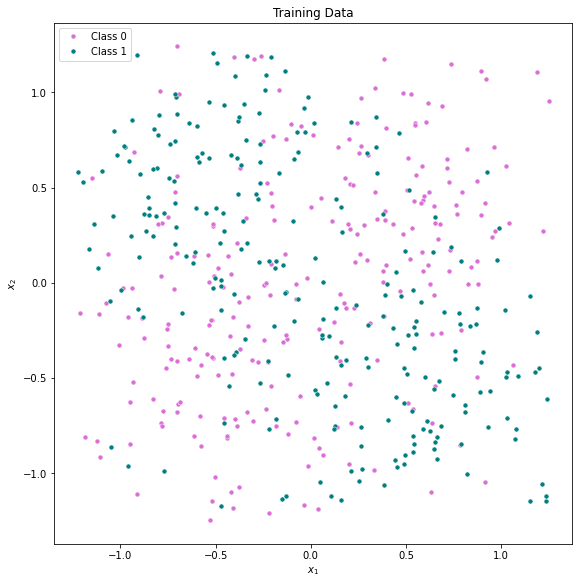

In [3]:
import matplotlib.pyplot as plt

# Code to plot the sample data
def plot_data(ax,X,y,title, limits):
    # Select the colors to use in the plots
    color0 = 'orchid'
    color1 = 'teal'
    color_boundary='snow'
    
    # Separate samples by class
    samples0 = X[y==0]
    samples1 = X[y==1]

    ax.plot(samples0[:,0],samples0[:,1],
        marker='o',
        markersize=5,
        linestyle="None",
        color=color0,
        markeredgecolor='w',
        markeredgewidth=0.5,
        label='Class 0')
    ax.plot(samples1[:,0],samples1[:,1],
        marker='o',
        markersize=5,
        linestyle="None",
        color=color1,
        markeredgecolor='w',
        markeredgewidth=0.5,
        label='Class 1')
    ax.set_title(title)
    ax.set_xlabel('$x_1$')
    ax.set_ylabel('$x_2$')
    ax.legend(loc='upper left')
    ax.set_aspect('equal')

fig, ax = plt.subplots(constrained_layout=True, figsize=(12,8))
limits = [-1.25, 1.25, -1.25, 1.25]
plot_data(ax, X_train, y_train, 'Training Data', limits)

The hyperparameters we want to explore control the architecture of our model and how our model is fit to our data. These hyperparameters include the (a) learning rate, (b) batch size, and the (c) regularization coefficient, as well as the (d) model architecture hyperparameters (the number of layers and the number of nodes per layer). We'll explore each of these and determine an optimized configuration of the network for this problem through this exercise. For all of the settings we'll explore and just, we'll assume the following default hyperparameters for the model (we'll use scikit learn's [`MLPClassifier`](https://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPClassifier.html#sklearn.neural_network.MLPClassifier.score) as our neural network model):
- `learning_rate_init` = 0.03
- `hidden_layer_sizes` = (30,30) (two hidden layers, each with 30 nodes)
- `alpha` = 0 (regularization penalty)
- `solver` = 'sgd' (stochastic gradient descent optimizer)
- `tol` = 1e-5 (this sets the convergence tolerance)
- `early_stopping` = False (this prevents early stopping)
- `activation` = 'relu' (rectified linear unit)
- `n_iter_no_change` = 1000 (this prevents early stopping)
- `batch_size` = 50 (size of the minibatch for stochastic gradient descent)
- `max_iter` = 500 (maximum number of epochs, which is how many times each data point will be used, not the number of gradient steps)

This default setting is our initial guess of what good values may be. Notice there are many model hyperparameters in this list: any of these could potentially be options to search over. We constrain the search to those hyperparameters that are known to have a significant impact on model performance.

**Part (a) Visualize the impact of different hyperparameter choices on classifier decision boundaries.** Visualize the impact of different hyperparameter settings. Starting with the default settings above make the following changes (only change one hyperparameter at a time). For each hyperparameter value, plot the decision boundary on the training data (you will need to train the model once for each parameter value):
1. Vary the architecture (`hidden_layer_sizes`) by changing the number of nodes per layer while keeping the number of layers constant at 2: (2,2), (5,5), (30,30). Here (X,X) means a 2-layer network with X nodes in each layer.
2. Vary the learning rate: 0.0001, 0.01, 1
3. Vary the regularization: 0, 1, 10
4. Vary the batch size: 5, 50, 500

As you're exploring these settings, visit this website, the [Neural Network Playground](https://playground.tensorflow.org/#activation=relu&batchSize=10&dataset=xor&regDataset=reg-plane&learningRate=0.03&regularizationRate=0&noise=20&networkShape=2,1&seed=0.89022&showTestData=false&discretize=false&percTrainData=50&x=true&y=true&xTimesY=false&xSquared=false&ySquared=false&cosX=false&sinX=false&cosY=false&sinY=false&collectStats=false&problem=classification&initZero=false&hideText=false&showTestData_hide=false), which will give you the chance to interactively explore the impact of each of these parameters on a similar dataset to the one we use in this exercise. The tool also allows you to adjust the learning rate, batch size, regularization coefficient, and the architecture and to see the resulting decision boundary and learning curves. You can also visualize the model's hidden node output and its weights, and it allows you to add in transformed features as well. Experiment by adding or removing hidden layers and neurons per layer and vary the hyperparameters.

**Part (a): Answer** Make 12 plots

Row 1:
Column 1 = Hidden layer of (2,2)
Column 2 = Hidden layer of (5,5)
Column 3 = Hidden layer of (30,30)

In [4]:
from sklearn.neural_network import MLPClassifier
hidden_layers = [(2,2), (5,5), (30,30)]
hidden_layer_class = []

for i in hidden_layers:
    clf1 = MLPClassifier(
        hidden_layer_sizes=i,
        activation="relu",
        solver="sgd",
        alpha=0,
        batch_size=50,
        learning_rate='constant',
        learning_rate_init=0.03,
        power_t=0.5,
        max_iter=500,
        shuffle=True,
        random_state=None,
        tol=1e-5,
        verbose=False,
        warm_start=False,
        momentum=0.9,
        nesterovs_momentum=True,
        early_stopping=False,
        validation_fraction=0.1,
        beta_1=0.9,
        beta_2=0.999,
        epsilon=1e-08,
        n_iter_no_change=1000,
        max_fun=15000,
    ).fit(X_train, y_train)
    clf1.predict_proba(X_test[:1])

    clf1.predict(X_test[:5, :])

    clf1.score(X_test, y_test)
    hidden_layer_class.append(clf1)


Row 2:
Column 1 = Learning rate of 0.0001
Column 2 = Learning rate of 0.01
Column 3 = Learning rate of 1

In [5]:
learning_rates = [0.0001, 0.01, 1]
learning_rate_trials = []

for i in learning_rates:
    clf2 = MLPClassifier(
        hidden_layer_sizes=(30,30),
        activation="relu",
        solver="sgd",
        alpha=0,
        batch_size=50,
        learning_rate='constant',
        learning_rate_init=i,
        power_t=0.5,
        max_iter=500,
        shuffle=True,
        random_state=None,
        tol=1e-5,
        verbose=False,
        warm_start=False,
        momentum=0.9,
        nesterovs_momentum=True,
        early_stopping=False,
        validation_fraction=0.1,
        beta_1=0.9,
        beta_2=0.999,
        epsilon=1e-08,
        n_iter_no_change=1000,
        max_fun=15000,
    ).fit(X_train, y_train)
    clf2.predict_proba(X_test[:1])

    clf2.predict(X_test[:5, :])

    clf2.score(X_test, y_test)
    learning_rate_trials.append(clf2)

Row 3:
Column 1 = Regularization of 0
Column 2 = Regularization of 1
Column 3 = Regularization of 10

In [6]:
Regularization_number = [0, 1, 10]
regularization_trials = []

for i in Regularization_number:
    clf3 = MLPClassifier(
        hidden_layer_sizes=(30,30),
        activation="relu",
        solver="sgd",
        alpha=i,
        batch_size=50,
        learning_rate='constant',
        learning_rate_init=0.03,
        power_t=0.5,
        max_iter=500,
        shuffle=True,
        random_state=None,
        tol=1e-5,
        verbose=False,
        warm_start=False,
        momentum=0.9,
        nesterovs_momentum=True,
        early_stopping=False,
        validation_fraction=0.1,
        beta_1=0.9,
        beta_2=0.999,
        epsilon=1e-08,
        n_iter_no_change=1000,
        max_fun=15000,
    ).fit(X_train, y_train)
    clf3.predict_proba(X_test[:1])

    clf3.predict(X_test[:5, :])

    clf3.score(X_test, y_test)
    regularization_trials.append(clf3)

Row 4:
Column 1 = Batch size of 5
Column 2 = Batch size of 50
Column 3 = Batch size of 500

In [7]:
Batch_sizes = [5, 50, 500]
batch_size_trials = []

for i in Batch_sizes:
    clf4 = MLPClassifier(
        hidden_layer_sizes=(30,30),
        activation="relu",
        solver="sgd",
        alpha=0,
        batch_size=i,
        learning_rate='constant',
        learning_rate_init=0.03,
        power_t=0.5,
        max_iter=500,
        shuffle=True,
        random_state=None,
        tol=1e-5,
        verbose=False,
        warm_start=False,
        momentum=0.9,
        nesterovs_momentum=True,
        early_stopping=False,
        validation_fraction=0.1,
        beta_1=0.9,
        beta_2=0.999,
        epsilon=1e-08,
        n_iter_no_change=1000,
        max_fun=15000,
    ).fit(X_train, y_train)
    clf4.predict_proba(X_test[:1])

    clf4.predict(X_test[:5, :])

    clf4.score(X_test, y_test)
    batch_size_trials.append(clf4)

Plot the data

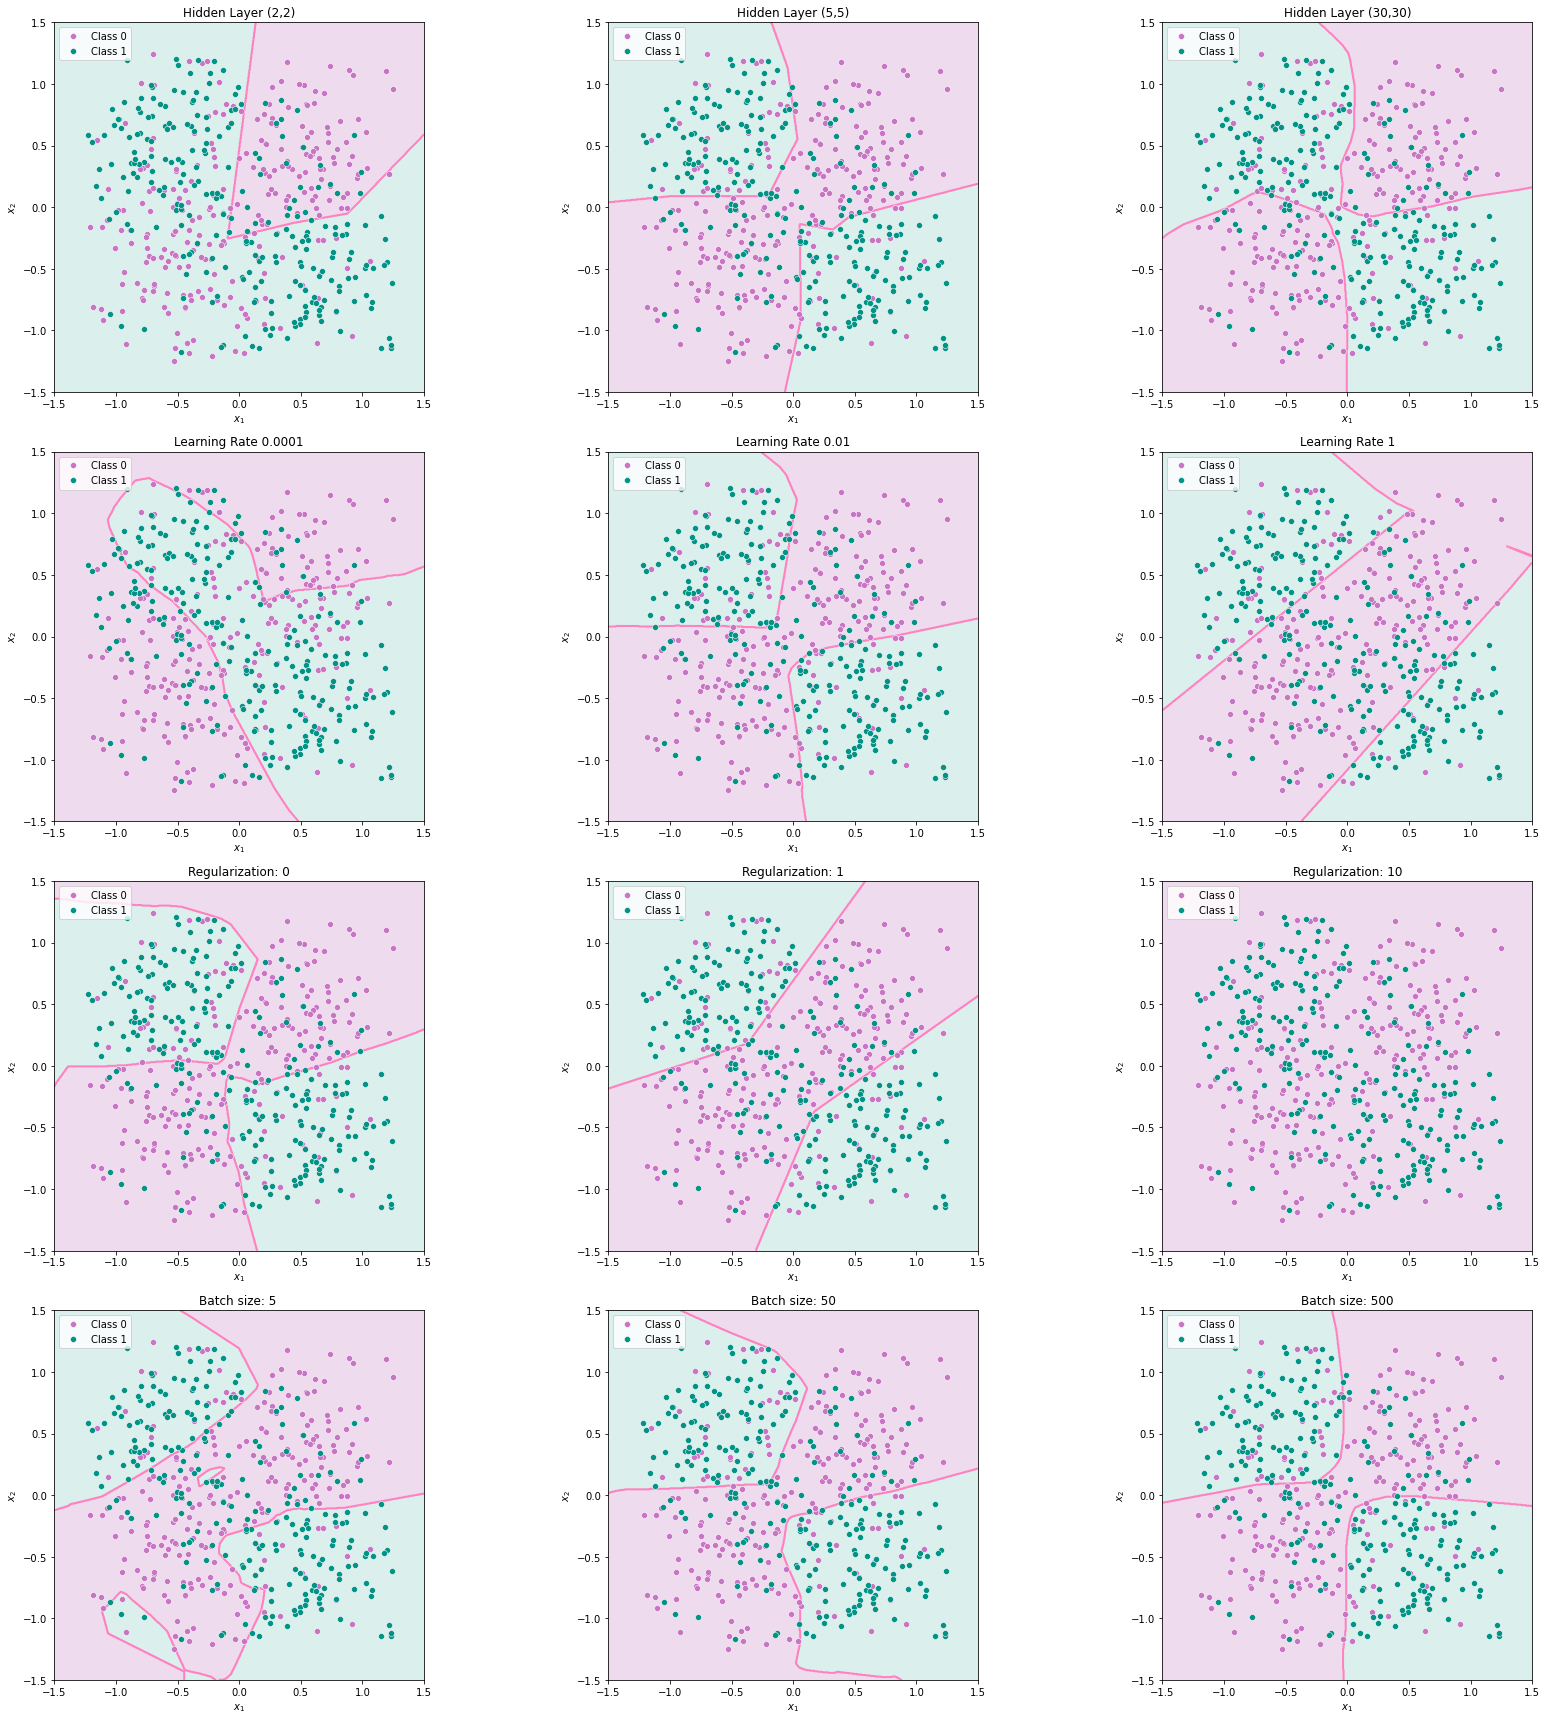

In [8]:
import matplotlib.pyplot as plt
import numpy as np
import colorsys
import matplotlib.colors as colors
import seaborn as sns

# Plots a decision boundary for a binary classifier
def showboundary(ax,limits,model,color0='#000000', color1='#FFFFFF',color_boundary='#000000', n=500):
    # Create the colormap with lighter colors for the background
    
    #---------------------------------------------------------
    # COLORS
    #---------------------------------------------------------
    
    # Convert hex colors to RGB values
    def hex2rgb(hex):
        hex = hex.replace('#', '')
        return np.array([int(hex[i:i+2], 16) for i in (0, 2, 4)])
    
    # Lightens the color to use as a background
    def lighten(hex_color, lighten_factor, saturation_factor):
        rgb = hex2rgb(hex_color)/255
        hls = colorsys.rgb_to_hls(*rgb)
        hls_new = list(hls)
        
        # Check if color is black (lightness is really low), 
        #  if so, set saturation zero to preserve saturation
        hls_new[1] = lighten_factor
        if hls[1] < 0.15:
            hls_new[2] = 0
        elif hls[1] > 0.95:
            hls_new[2] = 0
            hls_new[1] = 1
        else:
            hls_new[2] = saturation
        
        rgb_new = np.array(colorsys.hls_to_rgb(*hls_new))
        return (rgb_new*255).astype(np.uint8)
    
    # Create the background colors
    lightness = 0.9
    saturation = 0.4
    color0_background = lighten(color0, lightness, saturation)
    color1_background = lighten(color1, lightness, saturation)
    
    # Create the colormap to use in the plots
    nsteps = 2
    custom_cmap = np.array([np.linspace(i,j,nsteps) for i,j in zip(color0_background,color1_background)]).T
    cm = colors.ListedColormap(custom_cmap/255.0)

    #---------------------------------------------------------
    # BACKGROUND DATA
    #---------------------------------------------------------
    
    # Create the background data
    x   = np.linspace(limits[0],limits[1],n)
    y   = np.linspace(limits[2],limits[3],n)
    X,Y = np.meshgrid(x,y)
    shape = X.shape

    # Reshape into individual vectors
    Xv = X.reshape(-1)
    Yv = Y.reshape(-1)
    Pv = np.array([Xv,Yv]).T

    # Compute the prediction at each point in the grid
    predictions = model.predict(Pv)
    predictions_matrix = predictions.reshape(shape)

    #---------------------------------------------------------
    # PLOT THE DECISION BOUNDARY AND CLASSES
    #---------------------------------------------------------
    # Plot the background colors
    ax.imshow(np.flipud(predictions_matrix),extent=limits,cmap=cm)

    # Plot the contour
    ax.contour(x,y,predictions_matrix, [0.5], 
                colors=color_boundary,
                linewidths=2,
                linestyles='solid')
    
    # Plot the rest of the plot components
    ax.axis('square')
    ax.axis(limits)
# plot the sample data
def plot_data_and_boundary(ax,X,y,model,title):
    # Select the colors to use in the plots
    color0 = '#C875C4' # Orchid
    color1 = '#029386' # Teal
    color_boundary='#FF81C0' # Pink
    
    # Separate samples by class
    samples0 = X[y==0]
    samples1 = X[y==1]

    # Get the boundaries of the data
    lim = [-1.5,1.5,-1.5,1.5]
    showboundary(ax, lim, model, 
                 color0=color0, 
                 color1=color1, 
                 color_boundary=color_boundary, 
                 n=700)
    ax.plot(samples0[:,0],samples0[:,1],
        marker='o',
        markersize=6,
        linestyle="None",
        color=color0,
        markeredgecolor='w',
        markeredgewidth=0.5,
        label='Class 0')
    ax.plot(samples1[:,0],samples1[:,1],
        marker='o',
        markersize=6,
        linestyle="None",
        color=color1,
        markeredgecolor='w',
        markeredgewidth=0.5,
        label='Class 1')
    ax.set_title(title)
    ax.set_xlabel('$x_1$')
    ax.set_ylabel('$x_2$')
    ax.legend(loc='upper left')

fig, axs = plt.subplots(4, 3, figsize=(24,24))
plot_data_and_boundary(axs[0,0], X_train, y_train, hidden_layer_class[0], 'Hidden Layer (2,2)')
plot_data_and_boundary(axs[0,1], X_train, y_train, hidden_layer_class[1], 'Hidden Layer (5,5)')
plot_data_and_boundary(axs[0,2], X_train, y_train, hidden_layer_class[2], 'Hidden Layer (30,30)')
plot_data_and_boundary(axs[1,0], X_train, y_train, learning_rate_trials[0], 'Learning Rate 0.0001')
plot_data_and_boundary(axs[1,1], X_train, y_train, learning_rate_trials[1], 'Learning Rate 0.01')
plot_data_and_boundary(axs[1,2], X_train, y_train, learning_rate_trials[2], 'Learning Rate 1')
plot_data_and_boundary(axs[2,0], X_train, y_train, regularization_trials[0], 'Regularization: 0')
plot_data_and_boundary(axs[2,1], X_train, y_train, regularization_trials[1], 'Regularization: 1')
plot_data_and_boundary(axs[2,2], X_train, y_train, regularization_trials[2], 'Regularization: 10')
plot_data_and_boundary(axs[3,0], X_train, y_train, batch_size_trials[0], 'Batch size: 5 ')
plot_data_and_boundary(axs[3,1], X_train, y_train, batch_size_trials[1], 'Batch size: 50')
plot_data_and_boundary(axs[3,2], X_train, y_train, batch_size_trials[2], 'Batch size: 500')
plt.tight_layout()
plt.show()

**Part (b) Manual (greedy) hyperparameter tuning I: manually optimize hyperparameters that govern the learning process, one hyperparameter at a time.** Now with some insight into which settings may work better than others, let's more fully explore the performance of these different settings in the context of our validation dataset through a manual optimization process. Holding all else constant (with the default settings mentioned above), vary each of the following parameters as specified below. Train your algorithm on the training data, and evaluate the performance of your trained algorithm on the validation dataset. Here, overall accuracy is a reasonable performance metric since the classes are balanced and we don't weight one type of error as more important than the other; therefore, use the `score` method of the `MLPClassifier` for this. Create plots of accuracy vs each parameter you vary (this will result in three plots).
1. Vary learning rate logarithmically from $10^{-5}$ to $10^{0}$ with 20 steps
2. Vary the regularization parameter logarithmically from $10^{-8}$ to $10^2$ with 20 steps
3. Vary the batch size over the following values: $[1,3,5,10,20,50,100,250,500]$

For each of these cases:
- Based on the results, report your optimal choices for each of these hyperparameters and why you selected them.
- Since neural networks can be sensitive to initialization values, you may notice these plots may be a bit noisy. Consider this when selecting the optimal values of the hyperparameters. If the noise seems significant, run the fit and score procedure multiple times and report the average. Rerunning the algorithm will change the initialization and therefore the output (assuming you do not set a random seed for that algorithm).
- Use the chosen hyperparameter values as the new default settings for section (c) and (d).

**Part (b) Answer:**

In [9]:
from sklearn.linear_model import LogisticRegression
from tqdm import tqdm
np.random.seed(2018)

1. Vary learning rate

In [10]:
learn_rate_b = np.logspace(-5, 0, 20) # Pick a wide range of learning rates

learn_rate_model_b = []
for l in learn_rate_b:
    neuralnet = MLPClassifier(
        hidden_layer_sizes = (30,30),
        activation = 'relu',
        solver = 'sgd',
        alpha = 0,
        batch_size = 50,
        learning_rate_init=l, # Feed learning rate into Classifier
        max_iter=500,
        random_state=2018,
        tol=1e-5,
        early_stopping=False,
        n_iter_no_change=1000,
        ).fit(X_train, y_train)
    model = {
        "title": f"Regularization: {l}",
        "model": neuralnet,
        "param": l,
    }
    learn_rate_model_b.append(model)

<function seaborn.utils.despine(fig=None, ax=None, top=True, right=True, left=False, bottom=False, offset=None, trim=False)>

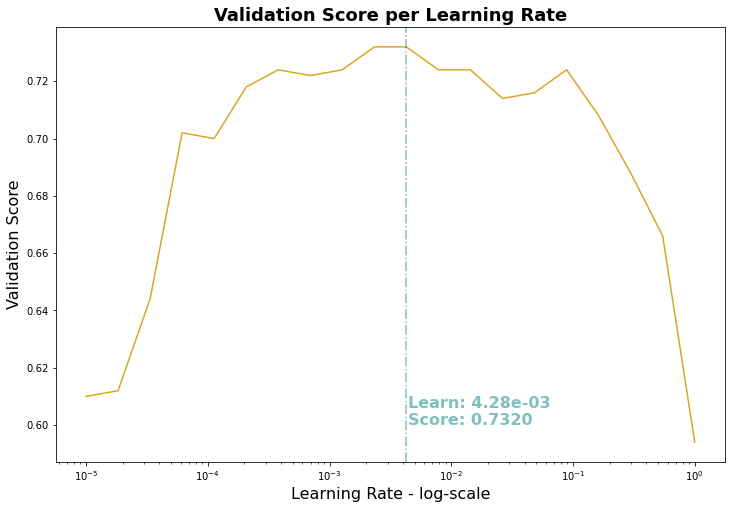

In [11]:
# Plot the validation scores by learning rates
learn_rate_scores = [model["model"].score(X_val, y_val) for model in learn_rate_model_b]

# Plot the line for validation score per learning rate
fig, ax = plt.subplots(figsize=(12, 8))
sns.lineplot(x=learn_rate_b, y=learn_rate_scores, color="goldenrod", ax=ax)
ax.set_xlabel("Learning Rate - log-scale", fontsize=16)
ax.set_ylabel("Validation Score", fontsize=16)
ax.set_title("Validation Score per Learning Rate", fontsize=18, fontweight="bold")
ax.set_xscale("log")

# add line that indicates optimal rates
optimal_learnrate = learn_rate_model_b[np.argsort(learn_rate_scores)[-2]]["param"]

ax.axvline(optimal_learnrate, color="teal", linestyle="-.", alpha=0.5)
ax.text(
    optimal_learnrate + 10e-5,
    0.6,
    s=f"Learn: {optimal_learnrate:.2e}\nScore: {learn_rate_scores[list(learn_rate_b).index(optimal_learnrate)]:.4f}",
    color="teal",
    fontsize=16,
    fontweight="bold",
    alpha=0.5,
)
sns.despine


The ideal learning rate is determined as 4.28e-03, though there is probably a range of numbers that could be picked around that exact point allowing for noise.

2. Vary regularization parameters

In [12]:
regularization_b = np.logspace(-8, 2, 20) # Pick a wide range of regularization options

regularization_model_b = []
for r in regularization_b:
    neuralnet = MLPClassifier(
        hidden_layer_sizes = (30,30),
        activation = 'relu',
        solver = 'sgd',
        alpha = r, # Feed regularizations into Classifier
        batch_size = 50,
        learning_rate_init=0.03,
        max_iter=500,
        random_state=2018,
        tol=1e-5,
        early_stopping=False,
        n_iter_no_change=1000,
        ).fit(X_train, y_train)
    model2 = {
        "title": f"Regularization: {r}",
        "model": neuralnet,
        "param": r,
    }
    regularization_model_b.append(model2)

<function seaborn.utils.despine(fig=None, ax=None, top=True, right=True, left=False, bottom=False, offset=None, trim=False)>

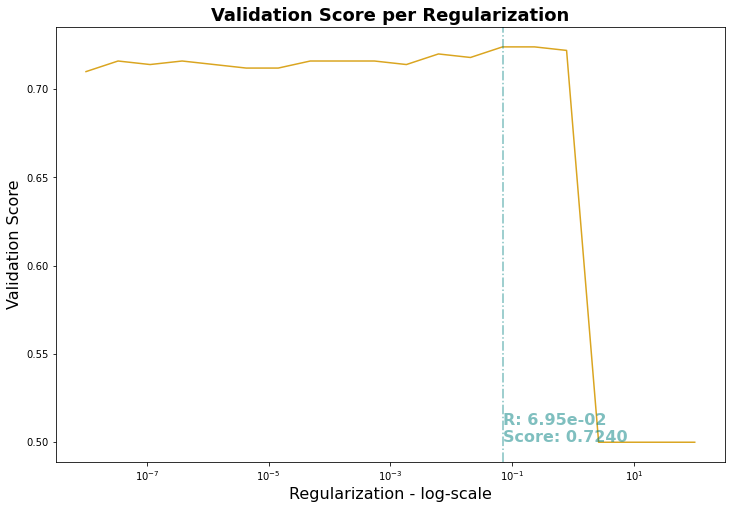

In [13]:
# Plot the validation scores by regularization rates
regularization_scores = [
    model["model"].score(X_val, y_val) for model in regularization_model_b
]

# Plot the line for validation score per regularization
fig, ax = plt.subplots(figsize=(12, 8))
sns.lineplot(x=regularization_b, y=regularization_scores, color="goldenrod", ax=ax)
ax.set_xlabel("Regularization - log-scale", fontsize=16)
ax.set_ylabel("Validation Score", fontsize=16)
ax.set_title("Validation Score per Regularization", fontsize=18, fontweight="bold")
ax.set_xscale("log")

# add line that indicates optimal rates
optimal_regularization = regularization_model_b[np.argsort(regularization_scores)[-2]][
    "param"
]

ax.axvline(optimal_regularization, color="teal", linestyle="-.", alpha=0.5)
ax.text(
    optimal_regularization + 10e-9,
    0.5,
    s=f"R: {optimal_regularization:.2e}\n"
    f"Score: {regularization_scores[list(regularization_b).index(optimal_regularization)]:.4f}",
    color="teal",
    fontsize=16,
    fontweight="bold",
    alpha=0.5,
)
sns.despine


The ideal regularization is determined as 6.95e-02, though there is probably a range of numbers that could be picked around that exact point allowing for noise.

3. Vary batch size

In [14]:
batch_size_b = [1, 3, 5, 10, 20, 50, 100, 250, 500]  # Pick a wide range of batch sizes

batch_size_model_b = []
for b in batch_size_b:
    neuralnet = MLPClassifier(
        hidden_layer_sizes=(30, 30),
        activation="relu",
        solver="sgd",
        alpha=0,
        batch_size=b,  # Feed batch sizes into Classifier
        learning_rate_init=0.03,
        max_iter=500,
        random_state=2003,
        tol=1e-5,
        early_stopping=False,
        n_iter_no_change=1000,
    ).fit(X_train, y_train)
    model3 = {
        "title": f"Batch Size: {b}",
        "model": neuralnet,
        "param": b,
    }
    batch_size_model_b.append(model3)


<function seaborn.utils.despine(fig=None, ax=None, top=True, right=True, left=False, bottom=False, offset=None, trim=False)>

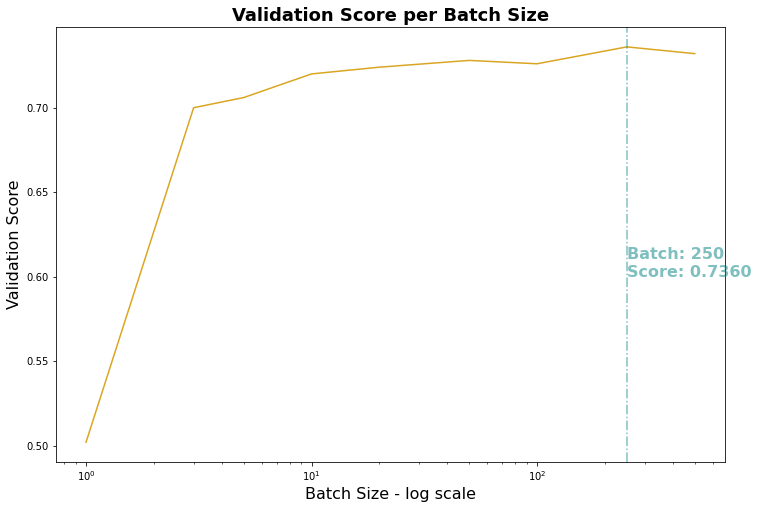

In [15]:
# Plot the validation scores by batch sizes
batch_scores = [model["model"].score(X_val, y_val) for model in batch_size_model_b]

# Plot the line for validation score per batch size
fig, ax = plt.subplots(figsize=(12, 8))
sns.lineplot(x=batch_size_b, y=batch_scores, color="goldenrod", ax=ax)
ax.set_xlabel("Batch Size - log scale", fontsize=16)
ax.set_ylabel("Validation Score", fontsize=16)
ax.set_title("Validation Score per Batch Size", fontsize=18, fontweight="bold")
ax.set_xscale("log")

# add line that indicates optimal batches
optimal_batch = batch_size_model_b[np.argsort(batch_scores)[-1]]["param"]

ax.axvline(optimal_batch, color="teal", linestyle="-.", alpha=0.5)
ax.text(
    optimal_batch + 10e-1,
    0.6,
    s=f"Batch: {optimal_batch:.0f}\nScore: {batch_scores[batch_size_b.index(optimal_batch)]:.4f}",
    color="teal",
    fontsize=16,
    fontweight="bold",
    alpha=0.5,
)
sns.despine


The ideal batch size is determined as 250, though there is probably a range of numbers that could be picked around that exact point allowing for noise.

**(c) Manual (greedy) hyperparameter tuning II: manually optimize hyperparameters that impact the model architecture.** Next, we want to explore the impact of the model architecture on performance and optimize its selection. This means varying two parameters at a time instead of one as above. To do this, evaluate the validation accuracy resulting from training the model using each pair of possible numbers of nodes per layer and number of layers from the lists below. We will assume that for any given configuration the number of nodes in each layer is the same (e.g. (2,2,2), which would be a 3-layer network with 2 hidden node in each layer and (25,25) are valid, but (2,5,3) is not because the number of hidden nodes varies in each layer). Use the manually optimized values for learning rate, regularization, and batch size selected from section (b). 
- Number of nodes per layer: $[1,2,3,4,5,10,15,25,30]$
- Number of layers = $[1,2,3,4]$
Report the accuracy of your model on the validation data. For plotting these results, use heatmaps to plot the data in two dimensions. To make the heatmaps, you can use [this code for creating heatmaps] https://matplotlib.org/stable/gallery/images_contours_and_fields/image_annotated_heatmap.html). Be sure to include the numerical values of accuracy in each grid square as shown in the linked example and label your x, y, and color axes as always. For these numerical values, round them to **2 decimal places** (due to some randomness in the training process, any further precision is not typically meaningful).
- When you select your optimized parameters, be sure to keep in mind that these values may be sensitive to the data and may offer the potential to have high variance for larger models. Therefore, select the model with the highest accuracy but lowest number of total model weights (all else equal, the simpler model is preferred). 
- What do the results show? Which parameters did you select and why?

**(c)** Manually optimize hyperparameters for architecture of neural network

In [16]:
# Define number of nodes per layer
node_list = [1, 2, 3, 4, 5, 10, 15, 25, 30]

# Define number of layers
layer_list = [1, 2, 3, 4]

# Define model architecture
architecture = []
for layer in layer_list:
    for node in node_list:
        tupel = (node,) * layer
        architecture.append(tupel)

# Define architecture in model
architecture_list = []
for a in architecture:
    neuralnet = MLPClassifier(
        hidden_layer_sizes = a,
        activation="relu",
        solver="sgd",
        alpha=6.95e-02,
        batch_size=250,
        learning_rate='constant',
        learning_rate_init=4.28e-03,
        power_t=0.5,
        max_iter=500,
        shuffle=True,
        random_state=2018,
        tol=1e-5,
        verbose=False,
        warm_start=False,
        momentum=0.9,
        nesterovs_momentum=True,
        early_stopping=False,
        validation_fraction=0.1,
        beta_1=0.9,
        beta_2=0.999,
        epsilon=1e-08,
        n_iter_no_change=1000,
        max_fun=15000,
    ).fit(X_train, y_train)
    model = {
        "title": f"Architecture: {a}",
        "model": neuralnet,
        "param": a,
    }
    architecture_list.append(model)

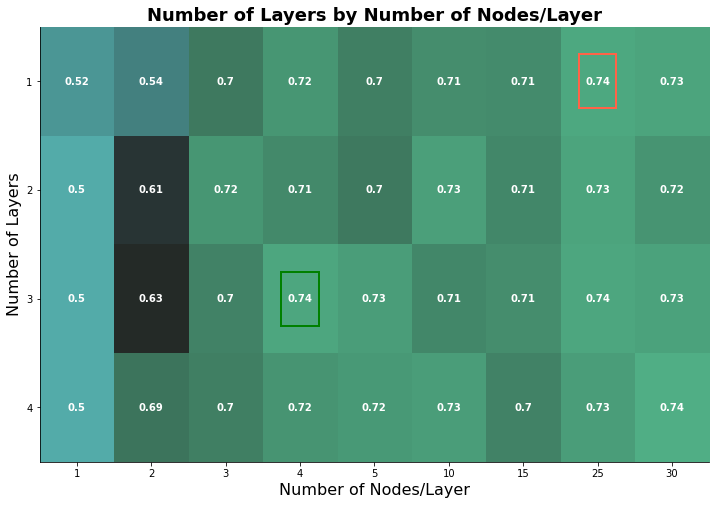

In [17]:
# Plot heatmap
import matplotlib.patches as patches

# Get architecture scores
architecture_scores = [
    model["model"].score(X_val, y_val) for model in architecture_list
]

# Turn scores into right shape
architecture_scores = np.array(architecture_scores).reshape(
    len(layer_list), len(node_list)
)

palette = sns.diverging_palette(550, 150, s=75, l=65, center="dark", as_cmap=True)

fig, ax = plt.subplots(figsize=(12, 8))
ax.imshow(X=architecture_scores, cmap=palette, aspect="auto", interpolation="none")
ax.set_xlabel("Number of Nodes/Layer", fontsize=16)
ax.set_ylabel("Number of Layers", fontsize=16)
ax.set_xticks(np.arange(len(node_list)), labels=node_list)
ax.set_yticks(np.arange(len(layer_list)), labels=layer_list)

for i in range(len(layer_list)):
    for j in range(len(node_list)):
        text = ax.text(
            j,
            i,
            architecture_scores[i, j].round(2), # round to two decimal places
            ha="center",
            va="center",
            color="w",
            fontsize=10,
            fontweight="bold",
        )
optimal_architecture = patches.Rectangle(
    xy=(2.75, 1.75), width=0.5, height=0.5, fill=False, edgecolor="green", linewidth=2
)
ax.add_patch(optimal_architecture)

optimal_architecture2 = patches.Rectangle(
    xy=(6.75, -0.25), width=0.5, height=0.5, fill=False, edgecolor="tomato", linewidth=2
)
ax.add_patch(optimal_architecture2)
ax.set_title(
    "Number of Layers by Number of Nodes/Layer", fontsize=18, fontweight="bold"
)

sns.despine()


- What do the results show? Which parameters did you select and why?

There are several options that show the same performance with the best score being reached being 0.74. I only consider combinations that reach this score, as I want the performance to be as high as possible. The option with the least hidden layers requires 25 nodes per layer, while the option with the lowest number of nodes per layer (4), requires 3 hidden layers. I pick the option with the least number of hidden layers and accept the higher node per layer tradeoff because the complexity of my model can be kept relatively low this way.

**(d) Manual (greedy) model selection and retraining.** Based the optimal choice of hyperparameters, train your model with your optimized hyperparameters on all the training data AND the validation data (this is provided as `X_train_plus_val` and `y_train_plus_val`). 
- Apply the trained model to the test data and report the accuracy of your final model on the test data.
- Plot an ROC curve of your performance (plot this with the curve in part (e) on the same set of axes you use for that question).

**(d)** Manual model training using training + validation set

In [18]:
# retrain on training + validation data with optimal hyperparameters
neuralnet_final = MLPClassifier(
    hidden_layer_sizes = (25,25),
    activation="relu",
    solver="sgd",
    alpha=6.95e-02,
    batch_size=250,
    learning_rate='constant',
    learning_rate_init=4.28e-03,
    power_t=0.5,
    max_iter=500,
    shuffle=True,
    random_state=2018,
    tol=1e-5,
    verbose=False,
    warm_start=False,
    momentum=0.9,
    nesterovs_momentum=True,
    early_stopping=False,
    validation_fraction=0.1,
    beta_1=0.9,
    beta_2=0.999,
    epsilon=1e-08,
    n_iter_no_change=1000,
    max_fun=15000,
).fit(X_train_plus_val, y_train_plus_val)

In [19]:
# apply final neuralnet to test data
neuralnet_final.fit(X_test, y_test)
test_acc = neuralnet_final.score(X_test, y_test)
print(f"The final neural network has an accuracy of: {test_acc} on the test dataset.")

The final neural network has an accuracy of: 0.738 on the test dataset.


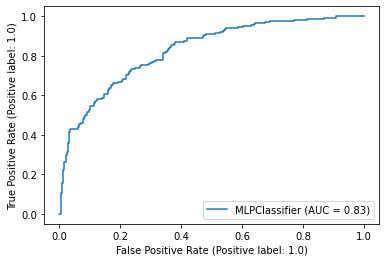

In [20]:
from sklearn import metrics
metrics.plot_roc_curve(neuralnet_final, X_test, y_test) 

**(e)** **Automated hyperparameter search through random search**. The manual (greedy) approach (setting one or two parameters at a time holding the rest constant), provides good insights into how the neural network hyperparameters impacts model fitting for this particular training process. However, it is limited in one very problematic way: it depends heavily on a good "default" setting of the hyperparameters. Those were provided for you in this exercise, but are not generally know. Our manual optimization was somewhat greedy because we picked the hyperparameters one at a time rather than looking at different combinations of hyperparameters. Adopting such a pseudo-greedy approach to that manual optimization also limits our ability to more deeply search the hyperparameter space since we don't look at simultaneous changes to multiple parameters. Now we'll use a popular hyperparameter optimization tool to accomplish that: random search.

Random search is an excellent example of a hyperparameter optimization search strategy that has [been shown to be more efficient](https://www.jmlr.org/papers/volume13/bergstra12a/bergstra12a?ref=https://githubhelp.com) (requiring fewer training runs) than another common approach: grid search. Grid search evaluates all possible combinations of hyperparameters from lists of possible hyperparameter settings - a very computationally expensive process. Yet another attractive alternative is [Bayesian Optimization](https://arxiv.org/abs/1807.02811), which is an excellent hyperparameter optimization strategy but we will leave that to the interested reader.

Our particular random search tool will be Scikit-Learn's [`RandomizedSearchCV`](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.RandomizedSearchCV.html#sklearn.model_selection.RandomizedSearchCV). This performs random search employing cross validation for performance evaluation (we will adjust this to ve a train/validation split). 

Using `RandomizedSearchCV`, train on the training data while validating on the validation data (see instructions below on how to setup the train/validation split automatically). This tool will randomly pick combinations of parameter values and test them out, returning the best combination it finds as measured by performance on the validation set. You can use [this example](https://scikit-learn.org/stable/auto_examples/model_selection/plot_randomized_search.html#sphx-glr-auto-examples-model-selection-plot-randomized-search-py) as a template for how to do this.
- To make this comparable to the training/validation setup used for the greedy optimization, we need to setup a training and validation split rather than use cross validation. To do this for `RandomSearchCV` we input the COMBINED training and validation dataset (`X_train_plus_val`, and `y_train_plus_val`) and we set the `cv` parameter to be the `train_val_split` variable we provided along with the dataset. This will setup the algorithm to make its assessments training just on the training data and evaluation on the validation data. Once `RandomSearchCV` completes its search, it will fit the model one more time to the combined training and validation data using the optimized parameters as we would want it to.
- Set the number of iterations to at least 200 (you'll look at 200 random pairings of possible hyperparameters). You can go as high as you want, but it will take longer the larger the value.
- If you run this on Colab or any system with multiple cores, set the parameter `n_jobs` to -1 to use all available cores for more efficient training through parallelization
- You'll need to set the range or distribution of the parameters you want to sample from. Search over the same ranges as in previous problems. To tell the algorithm the ranges to search, use lists of values for candidate batch_size, since those need to be integers rather than a range; the `loguniform` `scipy` function for setting the range of the learning rate and regularization parameter, and a list of tuples for the `hidden_layer_sizes` parameter, as you used in the greedy optimization.
- Once the model is fit, use the `best_params_` property of the fit classifier attribute to extract the optimized values of the hyperparameters and report those and compare them to what was selected through the manual, greedy optimization.

**(e)** Random Search

In [21]:
from time import time
import scipy.stats as stats
from sklearn.utils.fixes import loguniform

from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

# Prepare for search of number of hidden layers
# Define number of nodes per layer
node_list = [1, 2, 3, 4, 5, 10, 15, 25, 30]
# Define number of layers
layer_list = [1, 2, 3, 4]

# Define model architecture
hlayers = []
for layer in layer_list:
    for node in node_list:
        tupel = (node,) * layer
        hlayers.append(tupel)

# build the classifier
clf = MLPClassifier(
    activation="relu",
    solver="sgd",
    tol=1e-5,
    verbose=False,
    early_stopping=False,
    max_iter= 500,
    n_iter_no_change= 1000
)

# Utility function to report best scores
def report(results, n_top=3):
    for i in range(1, n_top + 1):
        candidates = np.flatnonzero(results["rank_test_score"] == i)
        for candidate in candidates:
            print("Model with rank: {0}".format(i))
            print(
                "Mean validation score: {0:.3f} (std: {1:.3f})".format(
                    results["mean_test_score"][candidate],
                    results["std_test_score"][candidate],
                )
            )
            print("Parameters: {0}".format(results["params"][candidate]))
            print("")


# specify parameters and distributions to sample from
param_dist = {
    "hidden_layer_sizes": hlayers, # iterate over same hidden layer sizes as in greedy search
    "learning_rate_init": loguniform(1e-5, 1), # iterate over same learning rates as in greedy search
    "batch_size": list(range(1, 500)), # iterate over same batch sizes as in greedy search
    "alpha": loguniform(1e-8, 1e-2) # iterate over the same regularization parameters as in greedy search
}

# run randomized search
n_iter_search = 500
random_search = RandomizedSearchCV(
    clf, param_distributions=param_dist, n_iter=n_iter_search, cv = train_val_split # Set cv parameter to train_val_split
)

start = time()
random_search.fit(X_train_plus_val, y_train_plus_val)
print(
    "RandomizedSearchCV took %.2f seconds for %d candidates parameter settings."
    % ((time() - start), n_iter_search)
)
report(random_search.cv_results_)


RandomizedSearchCV took 783.06 seconds for 500 candidates parameter settings.
Model with rank: 1
Mean validation score: 0.746 (std: 0.000)
Parameters: {'alpha': 3.0678938385814024e-07, 'batch_size': 450, 'hidden_layer_sizes': (25, 25, 25, 25), 'learning_rate_init': 0.12488536659457876}

Model with rank: 1
Mean validation score: 0.746 (std: 0.000)
Parameters: {'alpha': 5.055785080203197e-05, 'batch_size': 5, 'hidden_layer_sizes': (5,), 'learning_rate_init': 9.158052776878072e-05}

Model with rank: 1
Mean validation score: 0.746 (std: 0.000)
Parameters: {'alpha': 2.898312782205281e-07, 'batch_size': 455, 'hidden_layer_sizes': (15,), 'learning_rate_init': 0.01041924792675127}



In [22]:
# apply random search neuralnet to test data
clf.fit(X_test, y_test)
clf_acc = clf.score(X_test, y_test)
print(f"The final neural network has an accuracy of: {clf_acc} on the test dataset.")

The final neural network has an accuracy of: 0.73 on the test dataset.


For the final generalization performance assessment:
- State the accuracy of the optimized models on the test dataset

In [23]:
print(
    f"The final neural network, optimized with greedy search has an accuracy of: {test_acc} on the test dataset. \
        The neural network optimized through random search has an accuracy of {clf_acc}."
)


The final neural network, optimized with greedy search has an accuracy of: 0.738 on the test dataset.         The neural network optimized through random search has an accuracy of 0.73.


- Plot the ROC curve corresponding to your best model on the test dataset through greedy hyperparameter section vs the model identified through random search (these curves should be on the same set of axes for comparison). In the legend of the plot, report the AUC for each curve

Text(0.5, 0.98, 'ROC curve comparison')

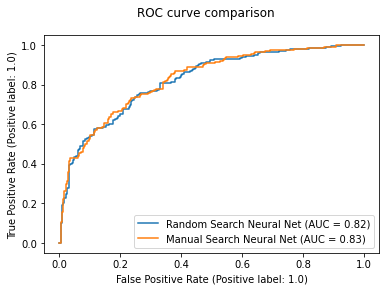

In [24]:
from sklearn.metrics import plot_roc_curve

clf_disp = plot_roc_curve(clf, X_test, y_test, name="Random Search Neural Net")
neuralnet_disp = plot_roc_curve(
    neuralnet_final, X_test, y_test, ax=clf_disp.ax_, name="Manual Search Neural Net"
)
neuralnet_disp.figure_.suptitle("ROC curve comparison")


- Plot the final decision boundary for the greedy and random search-based classifiers along with the test dataset to demonstrate the shape of the final boundary

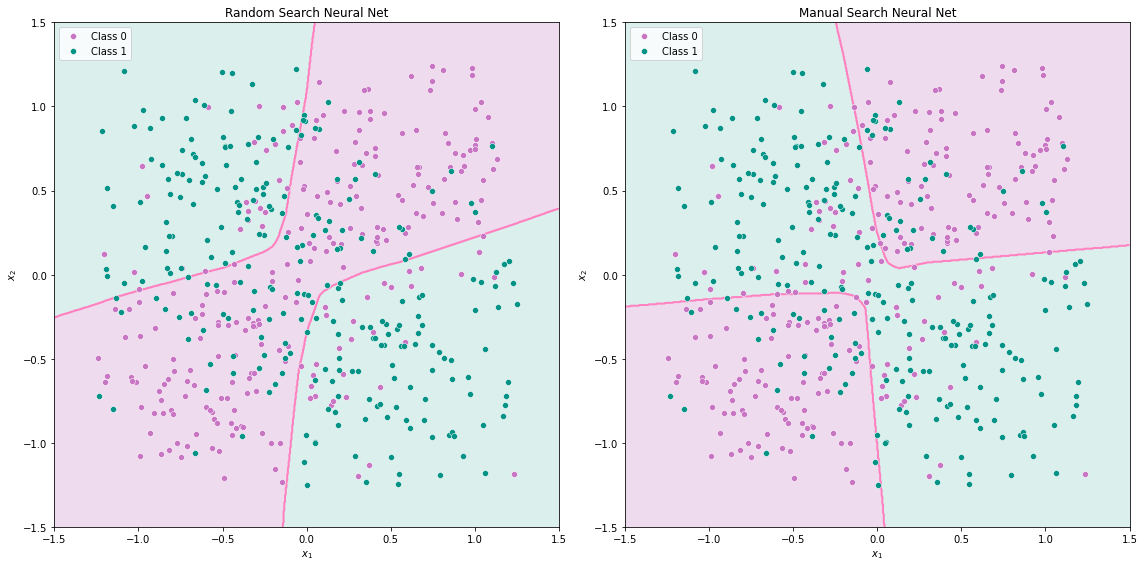

In [25]:
# Plots a decision boundary for a binary classifier
def showboundary(
    ax,
    limits,
    model,
    color0="#000000",
    color1="#FFFFFF",
    color_boundary="#000000",
    n=500,
):
    # Create the colormap with lighter colors for the background

    # ---------------------------------------------------------
    # COLORS
    # ---------------------------------------------------------

    # Convert hex colors to RGB values
    def hex2rgb(hex):
        hex = hex.replace("#", "")
        return np.array([int(hex[i : i + 2], 16) for i in (0, 2, 4)])

    # Lightens the color to use as a background
    def lighten(hex_color, lighten_factor, saturation_factor):
        rgb = hex2rgb(hex_color) / 255
        hls = colorsys.rgb_to_hls(*rgb)
        hls_new = list(hls)

        # Check if color is black (lightness is really low),
        #  if so, set saturation zero to preserve saturation
        hls_new[1] = lighten_factor
        if hls[1] < 0.15:
            hls_new[2] = 0
        elif hls[1] > 0.95:
            hls_new[2] = 0
            hls_new[1] = 1
        else:
            hls_new[2] = saturation_factor

        rgb_new = np.array(colorsys.hls_to_rgb(*hls_new))
        return (rgb_new * 255).astype(np.uint8)

    # Create the background colors
    lightness = 0.9
    saturation = 0.4
    color0_background = lighten(color0, lightness, saturation)
    color1_background = lighten(color1, lightness, saturation)

    # Create the colormap to use in the plots
    nsteps = 2
    custom_cmap = np.array(
        [
            np.linspace(i, j, nsteps)
            for i, j in zip(color0_background, color1_background)
        ]
    ).T
    cm = colors.ListedColormap(custom_cmap / 255.0)

    # ---------------------------------------------------------
    # BACKGROUND DATA
    # ---------------------------------------------------------

    # Create the background data
    x = np.linspace(limits[0], limits[1], n)
    y = np.linspace(limits[2], limits[3], n)
    X, Y = np.meshgrid(x, y)
    shape = X.shape

    # Reshape into individual vectors
    Xv = X.reshape(-1)
    Yv = Y.reshape(-1)
    Pv = np.array([Xv, Yv]).T

    # Compute the prediction at each point in the grid
    predictions = model.predict(Pv)
    predictions_matrix = predictions.reshape(shape)

    # ---------------------------------------------------------
    # PLOT THE DECISION BOUNDARY AND CLASSES
    # ---------------------------------------------------------
    # Plot the background colors
    ax.imshow(np.flipud(predictions_matrix), extent=limits, cmap=cm)

    # Plot the contour
    ax.contour(
        x,
        y,
        predictions_matrix,
        [0.5],
        colors=color_boundary,
        linewidths=2,
        linestyles="solid",
    )

    # Plot the rest of the plot components
    ax.axis("square")
    ax.axis(limits)


# plot the sample data
def plot_data_and_boundary(ax, X, y, model, title):
    # Select the colors to use in the plots
    color0 = "#C875C4"  # Orchid
    color1 = "#029386"  # Teal
    color_boundary = "#FF81C0"  # Pink

    # Separate samples by class
    samples0 = X[y == 0]
    samples1 = X[y == 1]

    # Get the boundaries of the data
    lim = [-1.5, 1.5, -1.5, 1.5]
    showboundary(
        ax,
        lim,
        model,
        color0=color0,
        color1=color1,
        color_boundary=color_boundary,
        n=700,
    )
    ax.plot(
        samples0[:, 0],
        samples0[:, 1],
        marker="o",
        markersize=6,
        linestyle="None",
        color=color0,
        markeredgecolor="w",
        markeredgewidth=0.5,
        label="Class 0",
    )
    ax.plot(
        samples1[:, 0],
        samples1[:, 1],
        marker="o",
        markersize=6,
        linestyle="None",
        color=color1,
        markeredgecolor="w",
        markeredgewidth=0.5,
        label="Class 1",
    )
    ax.set_title(title)
    ax.set_xlabel("$x_1$")
    ax.set_ylabel("$x_2$")
    ax.legend(loc="upper left")


fig, axs = plt.subplots(1, 2, figsize=(16, 12))
plot_data_and_boundary(axs[0], X_test, y_test, clf, "Random Search Neural Net")
plot_data_and_boundary(
    axs[1], X_test, y_test, neuralnet_final, "Manual Search Neural Net"
)
plt.tight_layout()
plt.show()


- How did the generalization performance compare between the hyperparameters selected through the manual (greedy) search and the random search?

The generalization performance between the hyperparameters selected through the manual search and the random search was very similar, though the manual search produced minimally better results with an accuracy of 0.74 over 0.73 and an AUC of 0.83 over 0.82. This means that neither of the networks shows great performance, as shown by the final decision boundary plots, where a lot of data-points would be misclassified by either model, but the performance could be considered reasonable.

# Question 2

## [45 points] Build and test your own Neural Network for classification

There is no better way to understand how one of the core techniques of modern machine learning works than to build a simple version of it yourself. In this exercise you will construct and apply your own neural network classifier. You may use numpy if you wish but no other libraries.

**(a)** Create a neural network class that follows the `scikit-learn` classifier convention by implementing `fit`, `predict`, and `predict_proba` methods. Your `fit` method should run backpropagation on your training data using stochastic gradient descent. Assume the activation function is a sigmoid. Choose your model architecture to have two input nodes, two hidden layers with five nodes each, and one output node.

To guide you in the right direction with this problem, please find a skeleton of a neural network class below. You absolutely MAY use additional methods beyond those suggested in this template, but the methods listed below are the minimum required to implement the model cleanly.

**Strategies for debugging**. One of the greatest challenges of this implementations is that there are many parts and a bug could be present in any of them. Here are some recommended tips:
- *Development environment*. Consider using an Integrated Development Environment (IDE). I strongly recommend the use of VS Code and the Python debugging tools in that development environment.
- *Unit tests*. You are strongly encouraged to create unit tests for most modules. Without doing this will make your code extremely difficult to bug. You can create simple examples to feed through the network to validate it is correctly computing activations and node values. Also, if you manually set the weights of the model, you can even calculate backpropagation by hand for some simple examples (admittedly, that unit test would be challenging and is optional, but a unit test is possible). 
- *Compare against a similar architecture*. You can also verify the performance of your overall neural network by comparing it against the `scikit-learn` implementation and using the same architecture and parameters as your model (your model outputs will certainly not be identical, but they should be somewhat similar for similar parameter settings).

**2a** 

I could not get it to work fully but I tried to build it and it runs without throwing an error now.

In [26]:
class myNeuralNetwork(object):
    
    def __init__(self, n_in, n_layer1, n_layer2, n_out, learning_rate):
        '''__init__
        Class constructor: Initialize the parameters of the network including
        the learning rate, layer sizes, and each of the parameters
        of the model (weights, placeholders for activations, inputs, 
        deltas for gradients, and weight gradients). This method
        should also initialize the weights of your model randomly
            Input:
                n_in:          number of inputs
                n_layer1:      number of nodes in layer 1
                n_layer2:      number of nodes in layer 2
                n_out:         number of output nodes
                learning_rate: learning rate for gradient descent
            Output:
                none
        '''
        # initialize the parameters
        self.n = n_in
        self.n_layer1 = n_layer1
        self.n_layer2 = n_layer2
        self.n_out = n_out
        self.lr = learning_rate
            
    def forward_propagation(self, x):
        '''forward_propagation
        Takes a vector of your input data (one sample) and feeds
        it forward through the neural network, calculating activations and
        layer node values along the way.
            Input:
                x: a vector of data representing 1 sample [n_in x 1]
            Output:
                y_hat: a vector (or scaler of predictions) [n_out x 1]
                (typically n_out will be 1 for binary classification)
        '''
        self.weights = [self.w1, self.w2, self.w3] # try to generalize
        self.a = [None, None, None]
        self.z = [x, None, None, None]
        for i in range(len(self.weights)):
            self.a[i] = self.z[i]@self.weights[i] # pre activation
            self.z[i+1] = self.sigmoid(self.a[i]) # post activation

        return self.z[-1] # is yhat
    
    def compute_loss(self, X, y):
        '''compute_loss
        Computes the current loss/cost function of the neural network
        based on the weights and the data input into this function.
        To do so, it runs the X data through the network to generate
        predictions, then compares it to the target variable y using
        the cost/loss function
            Input:
                X: A matrix of N samples of data [N x n_in]
                y: Target variable [N x 1]
            Output:
                loss: a scalar measure of loss/cost
        '''
        # Record yhat for each node
        y_hat = self.predict_proba(X)
        # Use Mean Squared Error
        MSE = np.mean((y_hat-y)**2)
        return MSE
    
    def backpropagate(self, x, y):
        '''backpropagate
        Backpropagate the error from one sample determining the gradients
        with respect to each of the weights in the network. The steps for
        this algorithm are:
            1. Run a forward pass of the model to get the activations 
               Corresponding to x and get the loss functionof the model 
               predictions compared to the target variable y
            2. Compute the deltas (see lecture notes) and values of the
               gradient with respect to each weight in each layer moving
               backwards through the network
    
            Input:
                x: A vector of 1 samples of data [n_in x 1]
                y: Target variable [scalar]
            Output:
                loss: a scalar measure of th loss/cost associated with x,y
                      and the current model weights
        '''
        yhat = self.forward_propagation(x)

        d_yhat = yhat - y.reshape(-1, 1)
        delta3 = d_yhat * self.sigmoid_derivative(self.a[-1])
        dweight3 = self.z[-1].T[:, None]@delta3
        
        delta2 = (delta3@self.weights[2].T)*self.sigmoid_derivative(self.a[1])
        dweight2 = self.z[1].T[:, None]@delta2

        delta1 = (delta2@self.weights[1].T)*self.sigmoid_derviative(self.a[0])
        dweight1 = self.z[0].T[:, None]@delta1

        self.deltas = [delta1, delta2, delta3]
        self.dweight = [dweight1.reshape(2, 5), dweight2[:, None].reshape(5, 5), dweight3[:, None].reshape(-1, 1)]

        return self.compute_loss(x, y)
        
    def stochastic_gradient_descent_step(self):
        '''stochastic_gradient_descent_step
        Using the gradient values computed by backpropagate, update each
        weight value of the model according to the familiar stochastic
        gradient descent update equation.
        
        Input: none
        Output: none
        '''
        for i in range(len(self.weights)):
            self.weights[i] -= self.lr*self.dedweight[i]
    
    def fit(self, X, X_val=None, max_epochs=1000, get_validation_loss=False):
        from sklearn.utils import shuffle
        '''fit
            Input:
                X: A matrix of N samples of data [N x n_in]
                y: Target variable [N x 1]
            Output:
                training_loss:   Vector of training loss values at the end of each epoch
                validation_loss: Vector of validation loss values at the end of each epoch
                                 [optional output if get_validation_loss==True]
        '''
        y=y.reshape(-1, 1) # Make one-dimensional
        training_loss = np.zeros(max_epochs) # record training loss
        validation_loss = np.zeros(max_epochs) # record validation loss

        X_shuffle, y_shuffle = shuffle(X, y) # Shuffle training data
        X_shuffle_val, y_shuffle_val = shuffle(X_val, y_val) # Shuffle validation data

        for epoch in range(max_epochs): # Use shuffled data for backpropagation and gradient descent
            for i in range(X_shuffle.shape[0]):
                self.backpropagate(X_shuffle[i:i+1], y_shuffle[i:i+1])
                self.stochastic_gradient_descent_step()
                pass
            training_loss[epoch] = self.compute_loss(X_shuffle_val, y_shuffle_val) # record training loss per epoch

            if get_validation_loss == True:
                validation_loss[epoch] = self.compute_loss(X_shuffle_val, y_shuffle_val) # record validation loss per epoch

            return training_loss, validation_loss
            
    def predict_proba(self, X):
        '''predict_proba
        Compute the output of the neural network for each sample in X, with the last layer's
        sigmoid activation providing an estimate of the target output between 0 and 1
            Input:
                X: A matrix of N samples of data [N x n_in]
            Output:
                y_hat: A vector of class predictions between 0 and 1 [N x 1]
        '''
        return np.apply_along_axis(self.forward_propagation, 1, X)
    
    def predict(self, X, decision_thresh=0.5):
        '''predict
        Compute the output of the neural network prediction for 
        each sample in X, with the last layer's sigmoid activation 
        providing an estimate of the target output between 0 and 1, 
        then thresholding that prediction based on decision_thresh
        to produce a binary class prediction
            Input:
                X: A matrix of N samples of data [N x n_in]
                decision_threshold: threshold for the class confidence score
                                    of predict_proba for binarizing the output
            Output:
                y_hat: A vector of class predictions of either 0 or 1 [N x 1]
        '''
        y_hat = (probs > decision_thres).astype(int)
        return y_hat
    
    def sigmoid(self, X):
        '''sigmoid
        Compute the sigmoid function for each value in matrix X
            Input:
                X: A matrix of any size [m x n]
            Output:
                X_sigmoid: A matrix [m x n] where each entry corresponds to the
                           entry of X after applying the sigmoid function
        '''
        sigmoid = np.exp(X)/(1 + np.exp(X))
        return sigmoid
    
    def sigmoid_derivative(self, X):
        '''sigmoid_derivative
        Compute the sigmoid derivative function for each value in matrix X
            Input:
                X: A matrix of any size [m x n]
            Output:
                X_sigmoid: A matrix [m x n] where each entry corresponds to the
                           entry of X after applying the sigmoid derivative function
        '''
        f = sigmoid
        df_dx = sigmoid * (1-sigmoid)
        return df_dx


**Part 2b) Apply your neural network** I use sklearn MLPClassifier and compare it to Random Forest Classifier at the end.

In [27]:
from sklearn.neural_network import MLPClassifier

# initialize model
neuralnet_Moons = MLPClassifier(
    hidden_layer_sizes = (25,25),
    activation = 'relu',
    solver = 'sgd',
    alpha = 0,
    batch_size = 250,
    learning_rate_init=0.03,
    max_iter=500,
    random_state=2018,
    tol=1e-5,
    early_stopping=False,
    n_iter_no_change=1000,
)

i) Create a training and validation dataset using `sklearn.datasets.make_moons(N, noise=0.20)`, where $N_{train} = 500$ and $N_{test} = 100$. **

In [28]:
from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split

from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt

# Get the initial amount of data
X, y = make_moons(
    n_samples=600, shuffle=True, noise=0.20, random_state=2018 # take a sample of 600 total
)  # final split will be: train = 400 + val = 100 + test = 100

# Split into train and test set
Moonsx_train, Moonsx_test, Moonsy_train, Moonsy_test = train_test_split(
    X, y, test_size = 1 / 6, random_state=2018
)  # tell it to use 100 for test set

# Split training set into training and validation set
Moonsx_train2, Moonsx_val, Moonsy_train2, Moonsy_val = train_test_split(
    Moonsx_train, Moonsy_train, test_size = 1 / 5, random_state=2018
) # tell it to use 100 for validation set


In [29]:
# Check that final training dataset has 400, validation has 100 and test has 100
print(Moonsx_train2.shape)
print(Moonsx_val.shape)
print(Moonsx_test.shape)

(400, 2)
(100, 2)
(100, 2)


Split has worked as expected.

ii) Train and test your model on this dataset plotting your learning curves (training and validation error for each epoch of stochastic gradient descent, where an epoch represents having trained on each of the training samples one time). 

In [30]:
import numpy as np
from sklearn import metrics

valloss = [] # Get validation error
trainloss = [] # get training error

# Use partial fit to loop
epochs = list(range(1, 501))
for e in epochs:
    neuralnet_Moons.partial_fit(Moonsx_train2, Moonsy_train2, classes=np.unique(Moonsy_train2))

    trainpred = neuralnet_Moons.predict_proba(Moonsx_train2)
    tloss = metrics.log_loss(Moonsy_train2, trainpred)
    trainloss.append(tloss)

    valpred = neuralnet_Moons.predict_proba(Moonsx_val)
    vloss = metrics.log_loss(Moonsy_val, valpred)
    valloss.append(vloss)

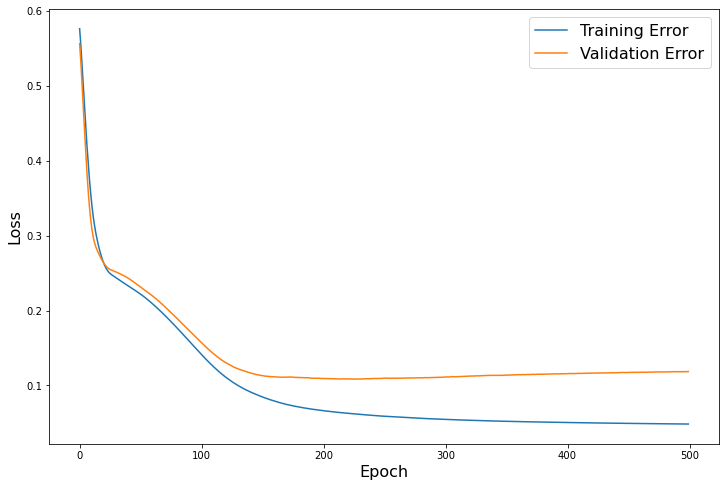

In [31]:
#Plot training and validation error/loss

fig, ax = plt.subplots(figsize = (12, 8))
ax.plot(np.arange(0, len(trainloss), 1), trainloss, label = "Training Error")
ax.plot(np.arange(0, len(valloss), 1), valloss, label = "Validation Error")
plt.xlabel("Epoch", fontsize = 16)
plt.ylabel("Loss", fontsize = 16)
plt.legend(fontsize = 16)

iii) Tune the learning rate and number of training epochs for your model to improve performance as needed. 

In [32]:
#tune learning rate

learn_rate = np.logspace(-5, 0, 20)

learn_rate_model = []
for l in learn_rate:
    #print(l)
    #print(type(l))
    neuralnet_Moons = MLPClassifier(
        activation = 'relu',
        solver = 'sgd',
        learning_rate_init = l, # Feed learning rates into Classifier
        random_state=2018
        ).fit(Moonsx_train2, Moonsy_train2)
    model = {
        "title": f"Learning Rate: {l}",
        "model": neuralnet_Moons,
        "param": l,
    }
    learn_rate_model.append(model)

In [33]:
# Tune epochs

epochs = [1, 200, 500, 1000, 10000]

epochs_model = []
for e in epochs:
    neuralnet_Moons = MLPClassifier(
        activation = 'relu',
        solver = 'sgd',
        max_iter = e, # feed epochs into Classifier
        random_state=2018 
        ).fit(Moonsx_train2, Moonsy_train2)
    model1 = {
        "title": f"Regularization: {l}",
        "model": neuralnet_Moons,
        "param": l,
    }
    epochs_model.append(model1)

Plot the reults

<function seaborn.utils.despine(fig=None, ax=None, top=True, right=True, left=False, bottom=False, offset=None, trim=False)>

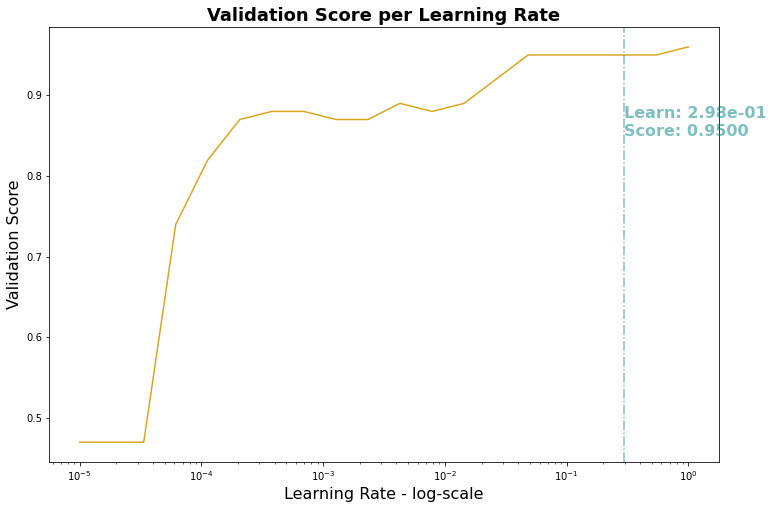

In [34]:
import seaborn as sns

# Plot the validation scores by learning rates
learn_rate_scores = [model["model"].score(Moonsx_val, Moonsy_val) for model in learn_rate_model]

# Plot the line for validation score per learning rate
fig, ax = plt.subplots(figsize=(12, 8))
sns.lineplot(x=learn_rate, y=learn_rate_scores, color="goldenrod", ax=ax)
ax.set_xlabel("Learning Rate - log-scale", fontsize=16)
ax.set_ylabel("Validation Score", fontsize=16)
ax.set_title("Validation Score per Learning Rate", fontsize=18, fontweight="bold")
ax.set_xscale("log")

# add line that indicates optimal rates
optimal_learnrate = learn_rate_model[np.argsort(learn_rate_scores)[-2]]["param"]

ax.axvline(optimal_learnrate, color="teal", linestyle="-.", alpha=0.5)
ax.text(
    optimal_learnrate + 10e-5,
    0.85,
    s=f"Learn: {optimal_learnrate:.2e}\nScore: {learn_rate_scores[list(learn_rate).index(optimal_learnrate)]:.4f}",
    color="teal",
    fontsize=16,
    fontweight="bold",
    alpha=0.5,
)
sns.despine

The optimal learning rate has been determined as 2.98e-01, though there are most likely several learning rates in the close vicinity that perform as well as this one, due to noise.

[0.47, 0.87, 0.87, 0.88, 0.88]
1000.0


<function seaborn.utils.despine(fig=None, ax=None, top=True, right=True, left=False, bottom=False, offset=None, trim=False)>

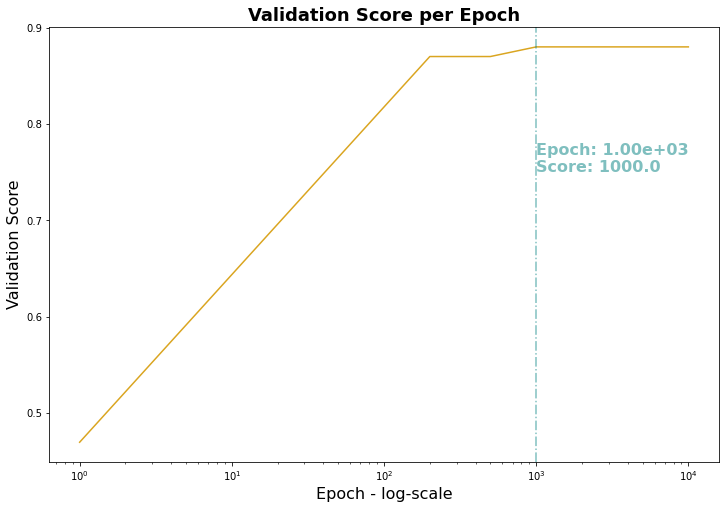

In [35]:
# Plot the validation scores by epochs
epoch_scores = [model["model"].score(Moonsx_val, Moonsy_val) for model in epochs_model]
print(epoch_scores)

# Plot the line for validation score per epoch
fig, ax = plt.subplots(figsize=(12, 8))
sns.lineplot(x=epochs, y=epoch_scores, color="goldenrod", ax=ax)
ax.set_xlabel("Epoch - log-scale", fontsize=16)
ax.set_ylabel("Validation Score", fontsize=16)
ax.set_title("Validation Score per Epoch", fontsize=18, fontweight="bold")
ax.set_xscale("log")

# add line that indicates optimal epoch
optimal_epoch = 10e02
print(optimal_epoch)

ax.axvline(optimal_epoch, color="teal", linestyle="-.", alpha=0.5)
ax.text(
    optimal_epoch + 10e-5,
    0.75,
    s=f"Epoch: {optimal_epoch:.2e}\nScore: {optimal_epoch:.1f}",
    color="teal",
    fontsize=16,
    fontweight="bold",
    alpha=0.5,
)
sns.despine

The optimal number of epochs has been determined as 1000, though there are most likely several epochs in the close vicinity that perform as well as this one, due to noise.

iv) In two subplots, plot the training data on one subplot, and the validation data on the other subplot. On each plot, also plot the decision boundary from your neural network trained on the training data. 

In [36]:
# reinitialize model with tuned parameters
neuralnet_Moons2 = MLPClassifier(
    hidden_layer_sizes = (25,25),
    activation = 'relu',
    solver = 'sgd',
    alpha = 0,
    batch_size = 250,
    learning_rate_init=2.98e-01,
    max_iter=1000,
    random_state=2018,
    tol=1e-5,
    early_stopping=False,
    n_iter_no_change=1000,
).fit(Moonsx_train, Moonsy_train)

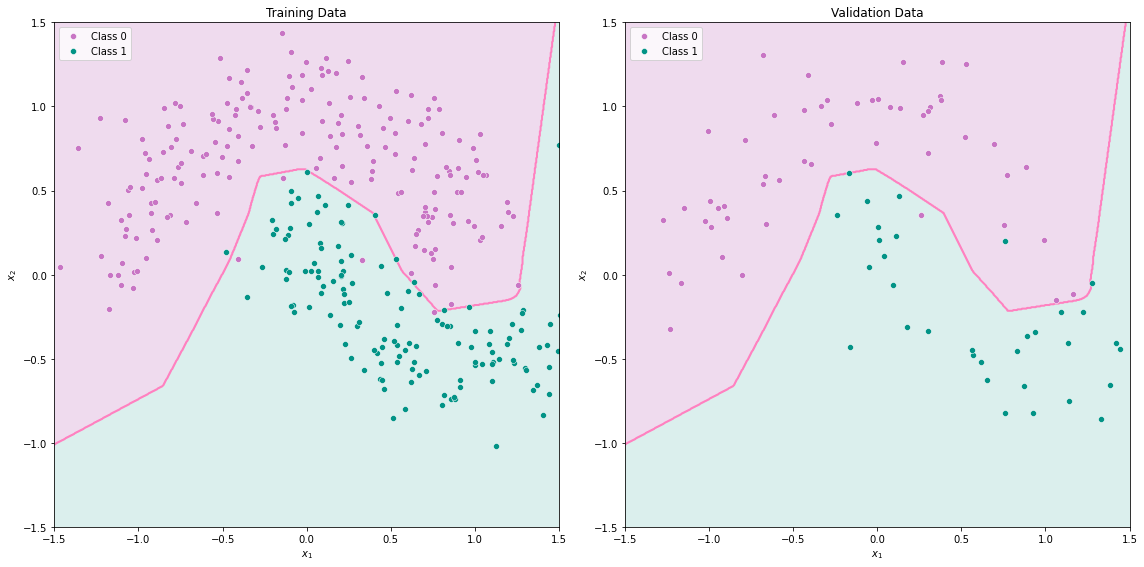

In [37]:
# Plots a decision boundary for a binary classifier
def showboundary(ax,limits,model,color0='#000000', color1='#FFFFFF',color_boundary='#000000', n=500):
    # Create the colormap with lighter colors for the background
    
    #---------------------------------------------------------
    # COLORS
    #---------------------------------------------------------
    
    # Convert hex colors to RGB values
    def hex2rgb(hex):
        hex = hex.replace('#', '')
        return np.array([int(hex[i:i+2], 16) for i in (0, 2, 4)])
    
    # Lightens the color to use as a background
    def lighten(hex_color, lighten_factor, saturation_factor):
        rgb = hex2rgb(hex_color)/255
        hls = colorsys.rgb_to_hls(*rgb)
        hls_new = list(hls)
        
        # Check if color is black (lightness is really low), 
        #  if so, set saturation zero to preserve saturation
        hls_new[1] = lighten_factor
        if hls[1] < 0.15:
            hls_new[2] = 0
        elif hls[1] > 0.95:
            hls_new[2] = 0
            hls_new[1] = 1
        else:
            hls_new[2] = saturation_factor
        
        rgb_new = np.array(colorsys.hls_to_rgb(*hls_new))
        return (rgb_new*255).astype(np.uint8)
    
    # Create the background colors
    lightness = 0.9
    saturation = 0.4
    color0_background = lighten(color0, lightness, saturation)
    color1_background = lighten(color1, lightness, saturation)
    
    # Create the colormap to use in the plots
    nsteps = 2
    custom_cmap = np.array([np.linspace(i,j,nsteps) for i,j in zip(color0_background,color1_background)]).T
    cm = colors.ListedColormap(custom_cmap/255.0)

    #---------------------------------------------------------
    # BACKGROUND DATA
    #---------------------------------------------------------
    
    # Create the background data
    x   = np.linspace(limits[0],limits[1],n)
    y   = np.linspace(limits[2],limits[3],n)
    X,Y = np.meshgrid(x,y)
    shape = X.shape

    # Reshape into individual vectors
    Xv = X.reshape(-1)
    Yv = Y.reshape(-1)
    Pv = np.array([Xv,Yv]).T

    # Compute the prediction at each point in the grid
    predictions = model.predict(Pv)
    predictions_matrix = predictions.reshape(shape)

    #---------------------------------------------------------
    # PLOT THE DECISION BOUNDARY AND CLASSES
    #---------------------------------------------------------
    # Plot the background colors
    ax.imshow(np.flipud(predictions_matrix),extent=limits,cmap=cm)

    # Plot the contour
    ax.contour(x,y,predictions_matrix, [0.5], 
                colors=color_boundary,
                linewidths=2,
                linestyles='solid')
    
    # Plot the rest of the plot components
    ax.axis('square')
    ax.axis(limits)

# plot the sample data
def plot_data_and_boundary(ax,X,y,model,title):
    # Select the colors to use in the plots
    color0 = '#C875C4' # Orchid
    color1 = '#029386' # Teal
    color_boundary='#FF81C0' # Pink
    
    # Separate samples by class
    samples0 = X[y==0]
    samples1 = X[y==1]

    # Get the boundaries of the data
    lim = [-1.5,1.5,-1.5,1.5]
    showboundary(ax, lim, model, 
                 color0=color0, 
                 color1=color1, 
                 color_boundary=color_boundary, 
                 n=700)
    ax.plot(samples0[:,0],samples0[:,1],
        marker='o',
        markersize=6,
        linestyle="None",
        color=color0,
        markeredgecolor='w',
        markeredgewidth=0.5,
        label='Class 0')
    ax.plot(samples1[:,0],samples1[:,1],
        marker='o',
        markersize=6,
        linestyle="None",
        color=color1,
        markeredgecolor='w',
        markeredgewidth=0.5,
        label='Class 1')
    ax.set_title(title)
    ax.set_xlabel('$x_1$')
    ax.set_ylabel('$x_2$')
    ax.legend(loc='upper left')

fig, axs = plt.subplots(1, 2, figsize=(16, 12))
plot_data_and_boundary(axs[0], Moonsx_train2, Moonsy_train2, neuralnet_Moons2, 'Training Data')
plot_data_and_boundary(axs[1], Moonsx_val, Moonsy_val, neuralnet_Moons2, 'Validation Data')
plt.tight_layout()
plt.show()

It looks like the MLP Classifier with the tuned hyperparameters performs well at separating the classes in the training and validation data.

v) Report your performance on the test data with an ROC curve and compare against the `scikit-learn` `MLPClassifier` trained with the same parameters. Use random forest classifier for comparison.

In [38]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier()
rf.fit(Moonsx_train2, Moonsy_train2)

RandomForestClassifier()

Text(0.5, 0.98, 'ROC curve comparison')

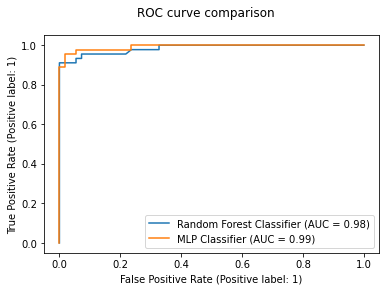

In [39]:
from sklearn.metrics import precision_recall_curve, roc_curve, auc

rf_disp = plot_roc_curve(rf, Moonsx_test, Moonsy_test, name = "Random Forest Classifier")
neuralnet_disp = plot_roc_curve(neuralnet_Moons2, Moonsx_test, Moonsy_test, ax=rf_disp.ax_, name = "MLP Classifier")
neuralnet_disp.figure_.suptitle("ROC curve comparison")

Both the Random Forest and the MLP Classifier perform very well on the test data, with an AUC of 0.99 for teh MLP classifier and 0.98 for the Random Forest Classifier (trained only on the training data). If I train the Random Forest Classifier on the combined training and validation data, the AUC increases to 0.99, too.

**(c)** Suggest two ways in which you neural network implementation could be improved: are there any options we discussed in class that were not included in your implementation that could improve performance?

There are several parameters, which could be used to improve the neural network implementation. For example, we did not test different values for early stopping or dropout rate. In addition, other hyperparameters could be tuned, such as batch size and regularization (like in exercise 1).